In [3]:
import pandas as pd
import pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
df = pd.read_pickle("data.pkl")
# Transfer the columns into approreate type
df.Bid = df.Bid.str.replace(",","").astype('float64')
df.Date = pd.to_datetime(df.Date)
df

# Drop the redundant columns and get dummies for categories columns
clean_df = pd.get_dummies(df.drop(["Year-Month Bid For", "Date"], axis=1), columns=["Company","Month","Week","Train_Type"], drop_first=True)
clean_df
df.columns

Index(['Date', 'Week', 'Month', 'Year', 'Company', 'Month Bid For',
       'Year Bid For', 'Near-Month Indicator', 'Train_Type', 'Bid',
       'Year-Month Bid For'],
      dtype='object')

In [5]:
class RailCarBidPredictor(nn.Module):
    def __init__(self, input_dim, h1=64, h2=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.ReLU(),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Linear(h2, 1),
        )
    def forward(self, x):
        return self.net(x)

In [6]:
lr, batch_size, hidden1, hidden2 = 0.01, 24, 256, 512
X = clean_df.drop("Bid", axis=1).values.astype(np.float32)
y = clean_df["Bid"].values.astype(np.float32).reshape(-1, 1)

model = RailCarBidPredictor(X.shape[1], hidden1, hidden2)
model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [ ]:
X_background_numpy = X
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_background_tensor = torch.from_numpy(X_background_numpy).float().to(device)

explainer = shap.DeepExplainer(model, X_background_tensor)
X_explain_tensor = torch.from_numpy(X_test).float().to(device)
shap_values = explainer.shap_values(X_explain_tensor)

In [13]:
with open(SAVE_DIR + 'shap_values.pkl', 'wb') as f:
    pickle.dump(shap_values, f)

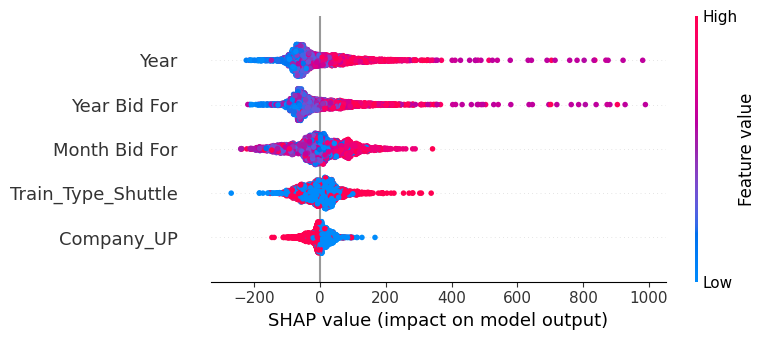

In [19]:
feature_names_list = clean_df.drop("Bid", axis=1).columns.tolist()

if isinstance(shap_values, torch.Tensor):
    shap_values_numpy = shap_values.cpu().numpy()
else:
    shap_values_numpy = shap_values

shap_values_2d = np.squeeze(shap_values_numpy)

shap.summary_plot(
    shap_values_2d,
    X_background_numpy,
    feature_names=feature_names_list,
    max_display=5
)

The summary plot shows the feature importance of each feature in the model. The results show that "Year", "Year Bid For", "Month Bid For" play major roles in determining the results.